## Evaluating classification techniques for speaker characterization
### Laura Fernández Gallardo

In this notebook, I will evaluate the performance of different classification techniques for characterizing users' warmth-attractiveness (WAAT). 

* Thesholding continuous scores generated from [factor analysis](https://github.com/laufergall/Subjective_Speaker_Characteristics/tree/master/speaker_characteristics/factor_analysis) based on percentiles to define 3 classes ("high", "mid", and "low") with approximately the same number of samples.
* Only the "high" and "low" classes are of interest -> I address **binary classification**.
* As evaluation metric, I will consider the average per-class accuracy

In [26]:
import io
import requests
import time # for timestamps
import pickle # save models

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# fix random seed for reproducibility
seed = 2302
np.random.seed(seed)

## Speakers' WAAT

WAAT (warmth-attractiveness) can be seen as the first two dimensions of the perceived speaker characteristics. Scaled (with mean = 0 and std = 1) scores of speakers on these dimensions were already extracted in the [subjective analysis](https://github.com/laufergall/Subjective_Speaker_Characteristics), for males and for females separately.


In [3]:
# load WAAT scores (averaged across listeners)

path = "https://raw.githubusercontent.com/laufergall/Subjective_Speaker_Characteristics/master/data/generated_data/"

url = path + "factorscores_malespk.csv"
s = requests.get(url).content
scores_m =pd.read_csv(io.StringIO(s.decode('utf-8')))

url = path + "factorscores_femalespk.csv"
s = requests.get(url).content
scores_f =pd.read_csv(io.StringIO(s.decode('utf-8')))

# rename dimensions
scores_m.columns = ['sample_heard', 'warmth', 'attractiveness', 'confidence', 'compliance', 'maturity']
scores_f.columns = ['sample_heard', 'warmth', 'attractiveness', 'compliance', 'confidence', 'maturity']

# join male and feame scores
scores = scores_m.append(scores_f)
scores['gender'] = scores['sample_heard'].str.slice(0,1)
scores['spkID'] = scores['sample_heard'].str.slice(1,4).astype('int')

scores.head()

,attractiveness,compliance,confidence,maturity,sample_heard,warmth,gender,spkID
0,-0.579301,-0.921918,0.608503,0.276580,m004_linden_stimulus.wav,-0.284638,m,4
1,0.442865,-0.950212,0.588889,0.630295,m005_nicosia_stimulus.wav,-0.494019,m,5
2,-0.507534,0.139302,-0.151077,-0.669449,m006_rabat_stimulus.wav,1.533478,m,6
3,1.180748,-0.108982,0.962166,1.026359,m007_klaksvik_stimulus.wav,0.478983,m,7
4,1.070247,-0.284278,-0.875589,-1.291311,m016_beirut_stimulus.wav,1.861551,m,16


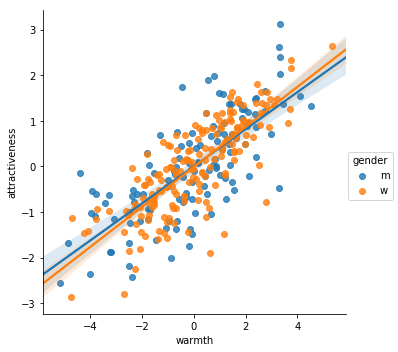

In [4]:
# scatter plot

sns.lmplot('warmth', 'attractiveness', data = scores, hue="gender")

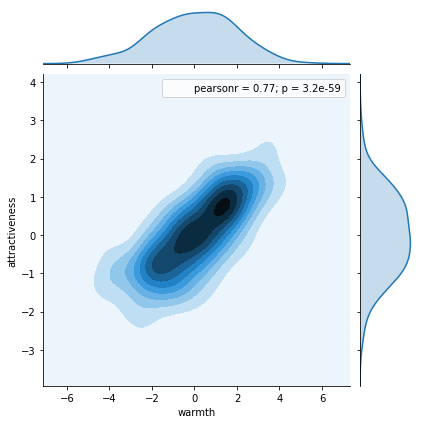

In [5]:
# histogram, kernel density estimation
sns.jointplot('warmth', 'attractiveness', data = scores, kind="kde").set_axis_labels("warmth", "attractiveness")

Get 3 clusters of speakers based on the WAAT distribution.
Each cluster with approx. the same number of instances.

mid     117
high    104
low      79
Name: class, dtype: int64


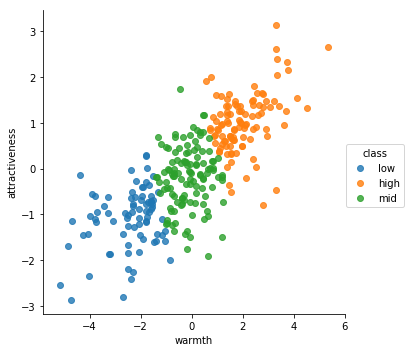

In [6]:
# applying k-means

n_clusters=3

kmeans = KMeans(n_clusters=n_clusters, random_state=2302).fit(scores[['warmth','attractiveness']])

scores['class'] = pd.Categorical(kmeans.labels_).rename_categories(['low','high','mid'])

sns.lmplot('warmth', 'attractiveness', data = scores, hue="class",fit_reg=False)
 
print(scores['class'].value_counts())    

## Select trait for binary classification and perform data partition

**Removing** speakers in the mid class to address binary classification.

In [7]:
# remove speakers in the mid class

scores = scores.loc[ scores['class'] != 'mid', ['spkID','gender','class']]

scores.head()


,spkID,gender,class
2,6,m,high
4,16,m,high
7,20,m,low
9,22,m,low
10,23,m,low


In [8]:
scores['class'] = pd.Categorical(scores['class'], categories=['low','high'])

print(scores.groupby(['gender','class']).count())

              spkID
gender class       
m      low       34
       high      46
w      low       45
       high      58


Split speakers into train (75%) and test (25%) speakers with class and gender balance (stratified) by creating the dummy "gendertrait" class.

In [29]:
# get stratified random partition for train and test

scores['genderclass']=scores[['gender', 'class']].apply(lambda x: ''.join(x), axis=1)

indexes = np.arange(0,len(scores))
classes = scores['class']
train_i, test_i, train_y, test_y = train_test_split(indexes, 
                                                    classes, 
                                                    test_size=0.25, 
                                                    stratify = scores['genderclass'], 
                                                    random_state=2302)

scores_train = scores.iloc[train_i,:] 
scores_test = scores.iloc[test_i,:] 

print('Number of speakers in Train:',len(scores_train))
print('Number of speakers in Test:',len(scores_test))

print('Number of w-high speakers in Train:', len(scores_train.loc[scores_train['genderclass']=='whigh']) )
print('Number of m-high speakers in Train:', len(scores_train.loc[scores_train['genderclass']=='mhigh']) )
print('Number of w-low speakers in Train:', len(scores_train.loc[scores_train['genderclass']=='wlow']) )
print('Number of m-high speakers in Train:', len(scores_train.loc[scores_train['genderclass']=='mlow']) )

print('Number of w-high speakers in Test:', len(scores_test.loc[scores_test['genderclass']=='whigh']) )
print('Number of m-high speakers in Test:', len(scores_test.loc[scores_test['genderclass']=='mhigh']) )
print('Number of w-low speakers in Test:', len(scores_test.loc[scores_test['genderclass']=='wlow']) )
print('Number of m-low speakers in Test:', len(scores_test.loc[scores_test['genderclass']=='mlow']) )


# # save these data for other evaluations
scores_train.iloc[:,0:3].to_csv(r'..\data\generated_data\speakerIDs_cls_WAAT_train.csv', index=False)
scores_test.iloc[:,0:3].to_csv(r'..\data\generated_data\speakerIDs_clss_WAAT_test.csv', index=False)

Number of speakers in Train: 137
Number of speakers in Test: 46
Number of w-high speakers in Train: 43
Number of m-high speakers in Train: 34
Number of w-low speakers in Train: 34
Number of m-high speakers in Train: 26
Number of w-high speakers in Test: 15
Number of m-high speakers in Test: 12
Number of w-low speakers in Test: 11
Number of m-low speakers in Test: 8


## Speech features

Speech features have been extracted from the semi-spontaneous dialogs uttered by the 300 speakers of the [NSC corpus](http://www.qu.tu-berlin.de/?id=nsc-corpus). 

Each semi-spontaneous dialog was splitted into 3 segments of approx. 20s, and the 88 [eGeMAPS](http://ieeexplore.ieee.org/document/7160715/) speech features were extracted from each segment (see ..\feature_extraction).

299 speakers recorded 4 semi-spontaneous dialogs, and 1 female speaker recorded 1 semi-spontaneous dialog. Total = 1197 dialogs * 3 segments = 3591 speech files.

Unfortunately, no subjective ratings have been collected for the spontaneous dialogs d5, d7, or d8. However, we use the speech features in order to have more instances with which to train and test the models.

**I assume** that the speakers' trait classes remain constant across recordings, that is, is a speaker is perceived as 'high' in the _intelligent_ trait for dialog 6 (d6, pizza dialog), then this perception would be the same for the other dialogs uttered by the same speaker.

In [10]:
# load speech features

path = "https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/extracted_features/"

url = path + "/eGeMAPSv01a_semispontaneous_splitted.csv"
s = requests.get(url).content
feats =pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ';') # shape: 3591, 89

feats.describe()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
count,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,...,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000
mean,32.074811,0.164822,29.331234,32.116749,34.979195,5.647962,214.705528,295.668503,169.914992,275.787170,...,0.010479,0.013236,0.071767,2.886362,2.007963,0.221566,0.165240,0.284134,0.417329,-36.338693
std,5.328665,0.048619,5.607906,5.591671,5.569061,1.795868,125.960017,250.885566,127.855815,271.865651,...,0.021249,0.002613,0.026480,0.582544,0.352177,0.043843,0.043784,0.076922,0.088756,3.655192
min,18.653170,0.042523,15.820370,17.475750,21.539220,1.861065,-1.284895,8.829769,-88.358820,5.645364,...,-0.081376,-0.003725,0.024064,1.254826,1.003764,0.100800,0.045621,0.114545,0.109176,-49.664970
25%,26.739480,0.130898,23.757365,26.487690,29.599050,4.400768,123.712800,118.036100,79.464975,81.877190,...,-0.003275,0.011667,0.053619,2.456779,1.758794,0.190541,0.134932,0.229104,0.361183,-38.860995
50%,34.306000,0.156014,31.710540,34.792220,37.338260,5.419893,185.773900,210.748100,130.231600,164.244500,...,0.011492,0.013374,0.066551,2.835696,2.007528,0.217083,0.159807,0.276333,0.417081,-36.402810
75%,36.630120,0.191418,34.186190,36.802260,39.593045,6.535017,273.657000,393.345000,225.026900,383.648100,...,0.025134,0.015017,0.083654,3.264876,2.225413,0.246432,0.189568,0.330000,0.472313,-34.025370
max,41.767930,0.391718,39.079370,42.096060,45.941690,18.397280,942.694600,1651.011000,1074.595000,1698.962000,...,0.077525,0.021781,0.226448,5.505506,3.355705,0.411176,0.447600,0.695000,1.885223,-24.326250


Pre-processing features with the transformation **learnt with training data**:

* center and scale speech features

In [37]:
# Separate instances according to the train and test partition
# instances corresponding to speakers in the mid class will be left out

# extract speaker ID from speech file name
feats['spkID'] = feats['name'].str.slice(2, 5).astype('int')

# appending class label
feats_class_train = pd.merge(feats, scores_train[['spkID','genderclass','class']], how='inner')
feats_class_test = pd.merge(feats, scores_test[['spkID','genderclass','class']], how='inner')

print('Number of high instances in Train:', len(feats_class_train.loc[feats_class_train['class']=='high']) )
print('Number of low instances in Train:', len(feats_class_train.loc[feats_class_train['class']=='low']) )
print('Number of high instances in Test:', len(feats_class_test.loc[feats_class_test['class']=='high']) )
print('Number of low instances in Test:', len(feats_class_test.loc[feats_class_test['class']=='low']) )


feats_class_train.head()

Number of high instances in Train: 924
Number of low instances in Train: 720
Number of high instances in Test: 324
Number of low instances in Test: 228


,name,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,...,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,spkID,genderclass,class
0,'m006_rabat_d5_01.wav',31.23358,0.262306,26.59388,30.09026,34.11197,7.518097,316.59510,610.79350,267.6818,...,2.910414,2.643574,0.201035,0.209331,0.180400,0.286503,-30.14587,6,mhigh,high
1,'m006_rabat_d5_02.wav',31.31265,0.205003,27.27562,31.13765,34.80304,7.527420,90.15386,78.50047,223.4587,...,2.228286,1.550388,0.253529,0.187034,0.405807,0.462146,-30.21316,6,mhigh,high
2,'m006_rabat_d5_03.wav',32.08952,0.210413,27.79275,31.72719,35.72678,7.934029,277.98860,632.48160,139.8396,...,2.590194,2.132591,0.233043,0.190101,0.229767,0.381140,-29.06304,6,mhigh,high
3,'m006_rabat_d6_01.wav',32.86148,0.209119,28.24504,32.85449,37.06210,8.817057,299.96070,709.52120,171.5547,...,3.178340,1.770956,0.304667,0.248820,0.247241,0.419860,-27.91848,6,mhigh,high
4,'m006_rabat_d6_02.wav',31.04583,0.249890,26.29376,29.80590,33.76602,7.472261,191.92640,177.29000,113.4793,...,2.354326,1.890136,0.239687,0.185363,0.317407,0.477544,-29.62095,6,mhigh,high


In [85]:
# Standardize speech features  

# save feature names
feats_names = feats_class_train.drop(['name','spkID','genderclass','class'],axis=1).columns

# learn transformation on training data
scaler = StandardScaler()
scaler.fit(feats_class_train.drop(['name','spkID','genderclass','class'],axis=1))

# numpy n_instances x n_feats
feats_s_train = scaler.transform(feats_class_train.drop(['name','spkID','genderclass','class'],axis=1))
feats_s_test = scaler.transform(feats_class_test.drop(['name','spkID','genderclass','class'],axis=1)) 

## Model tuning with feature selection

Use the train data to find the classifier and its hyperparameters leading to the best performance. Perform feature selection.

### Defining classifiers for hyperparam tuning

In [97]:
# all imports (classifiers)

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


"""
Naive Bayes Classifier
"""
def get_GaussianNB2tune():

    model = GaussianNB()
    hp = dict()
    return 'GaussianNB', model, hp

"""
Logistic Regression
"""
def get_LogisticRegression2tune():

    model = LogisticRegression()
    hp = dict(
        penalty = ['l1','l2']
    )
    return 'LogisticRegression', model, hp


"""
K Nearest Neighbors
"""
def get_KNeighborsClassifier2tune():

    model = KNeighborsClassifier()
    hp = dict(
        n_neighbors = list(range(1,50))
    )
    return 'KNeighborsClassifier', model, hp


"""
Support Vector Machines
"""
def get_SVC2tune():
    
    model = SVC()
    hp = dict(
        C = np.logspace(-5,3,num=9),
        kernel = ['poly'], #['linear', 'poly', 'rbf', 'sigmoid'],
        degree = [2] #, # only 'poly' kernel
        #gamma = np.logspace(-5,3,num=9)
    )
    return 'SVC', model, hp


"""
Decision Trees
"""
def get_DecisionTreeClassifier2tune():
    
    model = DecisionTreeClassifier()
    hp = dict(
        max_depth = np.arange(2,4)#np.arange(2,11)
    )
    return 'DecisionTreeClassifier', model, hp


"""
Random Forest
"""
def get_RandomForestClassifier2tune():
    
    model = RandomForestClassifier()
    hp = dict(
        n_estimators = np.arange(2,4)#np.arange(2,51)
    )
    return 'RandomForestClassifier', model, hp

In [98]:
"""
Summarize results of cross-validation on set A for hyperparameter tuning

Inputs:
- cname: classifier name
- grid_result: gridsearch results for this classifier, output of grid.fit(AX, Ay)  
- file: open file to write the summary to
"""
def summary_tuning(cname, grid_result, file):
    
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    # print best result and append to our lists
    print("%r -> Best cross-val on A set: %f using %s" % (cname, grid_result.best_score_, grid_result.best_params_))

    # write means, stds, params to file
    file.write("%r; %r; %r; %r\n" % ('model','mean_acc_A', 'stdev_acc_A', 'hyperparameters'))
    for mean, stdev, param in zip(means, stds, params):
        file.write("%r; %f; %f; %r\n" % (cname, mean, stdev, param))
      

    
"""
Save performances on B set of the best classifiers tuned with set A

Inputs:
- cnames: list of classifier names
- accs: list of accuracies on the B set
- hps: tuned hyperparameters of the classifiers 
- filename: name of the csv file to write these columns to
"""    
def summary_performance_on_B(cnames, accs, hps, filename):
    
    d = {
        'model': cnames,
        'accuracy_on_B': accs,
        'hyperparameters': hps
        }
    df = pd.DataFrame(data = d, columns = d.keys())
    df.to_csv('../data/generated_data/'+filename, index=False)
        
    
                           
        

"""
Perform nested hyperparameter tuning.
Split data into A, B sets and for each classifier type:
Stratified cross-validation for hyperparameter tuning using set A
Evaluate the performance on set B
Save accs on set B with timestamps to keep track of different experiments

Input:
- X: features of the train set
- y: labels of the train set
- get_cls_functions: list of functions tho get classifier and dict of hp to tune

Output: 
- name
- hyperparameters
- model trained on X data
of the best model selected after hp tuning
"""    

def hp_tuner(X, y, get_cls_functions):

    # split train data into 80% and 20% subsets - with balance in trait and gender
    # give subset A to the inner hyperparameter tuner,
    # save subset B for meta-evaluation
    AX, BX, Ay, By = train_test_split(X, y, test_size=0.20, stratify = feats_pca_class_train['gendertrait'], random_state=2302)

    print('Number of instances in A (hyperparameter tuning):',AX.shape[0])
    print('Number of instances in B (meta-evaluation):',BX.shape[0])

    # init lists

    classifiers_names = []
    classifiers = []
    hparam_grids = []
    grid_results = []
    best_accs = [] # on the B set
    best_hps = [] 

    # iterate over list of functions 
    # to get classifiers and parameters and append to our lists

    for fn in get_cls_functions:     
        clsname, cls, hp = fn()
        classifiers_names.append(clsname)
        classifiers.append(cls)
        hparam_grids.append(hp)
        
    # tune hyperparameters witzh GridSearchCV for each classifier
    
    for i in np.arange(len(classifiers)):

        # perform grid search
        grid = GridSearchCV(estimator=classifiers[i], 
                            param_grid=hparam_grids[i], 
                            n_jobs=1, 
                            cv=10)
        
        # This might take a while:
        grid_result = grid.fit(AX, Ay) 

        # append grid search results to our lists
        grid_results.append(grid_result)

        # summary of hp tuning
        # generate one csv file per classifier, in this folder
        timestr = time.strftime("%Y%m%d-%H%M%S")
        summary_tuning(classifiers_names[i], 
                       grid_result, 
                       open(classifiers_names[i]+'_tuning_'+timestr+'.csv','w'))

        # evaluate classifier on set B
        test_score = grid_result.best_estimator_.score(BX, By)
        print("%r -> Score on B set: %f\n" % (classifiers_names[i], test_score))
        best_accs.append(test_score)
        best_hps.append(grid_result.best_params_)

        # save classifier to disk
        filename = r'..\data\models\classification\tuned_'+ classifiers_names[i] + '.sav'
        pickle.dump(cls, open(filename, 'wb'))
      
    # save the accuracies on B to csv 
    timestr = time.strftime("%Y%m%d-%H%M%S")
    summary_performance_on_B(classifiers_names,
                             best_accs,
                             best_hps,
                             'classificationPerformance_on_B_' + timestr + '.csv')
        
    # select the classifier that gave the maximum acc on B set
    index = best_accs.index(max(best_accs))
    print("Selected: %r\n" % (classifiers_names[index]))
    cls = classifiers[index]
    cls.set_params(**best_hps[index])

    # train using all training data with this classifier
    cls.fit(X,y)

    # save trained classifier to disk
    filename = r'..\data\models\classification\trained_' + classifiers_names[index] + '.sav'
    pickle.dump(cls, open(filename, 'wb'))
    
    return classifiers_names[index], best_hps[index], cls

Main code snippet to evaluate classification accuracy:
    
* Choose data (feature and labels) for train X and y and test Xt and yt
* Hyperparameter tuner using train data by calling hp_tuner()
    * split train data into A and B
    * For each classifier type:
        * Stratified cross-validation for hyperparameter tuning using set A
        * Evaluate the performance on set B
    * Select classifier based on the best performance on set B and train it using all training data   
* Get performance on test set

(Nested hyperparameter tuning inspired by [A. Zheng](http://www.oreilly.com/data/free/evaluating-machine-learning-models.csp))


In [ ]:
# training data. Features and labels
X = feats_s_train
y = feats_class_train['class'].cat.codes

# test data. Features and labels
Xt = feats_s_test
yt = feats_class_test['class'].cat.codes

In [ ]:
# Hyperparameter tuner using train data by calling hp_tuner

get_cls_functions = [
    get_DecisionTreeClassifier2tune,
    get_RandomForestClassifier2tune
] 

bestmodel_name, bestmodel_hps, bestmodel_trained = hp_tuner(X, y, get_cls_functions)

In [ ]:
# Evaluate the performance of the best classifier (determined with train data) on the test set

# predictions on the test set
yt_pred = bestmodel_trained.predict(Xt)

score_on_test = bestmodel_trained.score(Xt,yt)

# plot confusion matrix as heatmap
cm = confusion_matrix(yt, yt_pred, labels=["low", "high"])
print(classification_report(yt, yt_pred, digits = 2))
print(cm)

# save to file: yt and yt_pred
d = {
    'wavfile': feats_class_test['name'],
    'true_label': yt,
    'predicted_label': yt_pred
}
df = pd.DataFrame(data = d, columns=d.keys())
df.to_csv(r'..\data\generated_data\ ' + target_trait + '_classification_predictions_'+ bestmodel_name + '_scored_' + str(round(score_on_test,2)) + '.csv', index=False)

In [93]:

# trying pipeline

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC


pipe = Pipeline([
    ('reduce_dim', SelectKBest(f_regression, k=5)),
    ('classify', SVC())
])

param_grid = [
    {
        'reduce_dim': [SelectKBest(f_regression, k=5), SelectKBest(mutual_info_classif)],
        'reduce_dim__k': [2, 4, 8],
        'classify__C': [1e-2, 1, 10]
    },
]
reducer_labels = ['KBest(freg5)', 'mutualInfo']

grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid)
grid_result = grid.fit(X, y) 

mean_scores = np.array(grid.cv_results_['mean_test_score'])


In [94]:
mean_scores

array([ 0.60523114,  0.56386861,  0.5620438 ,  0.59002433,  0.56812652,
        0.5620438 ,  0.66058394,  0.63686131,  0.66301703,  0.65693431,
        0.6526764 ,  0.66970803,  0.6526764 ,  0.62712895,  0.65328467,
        0.65510949,  0.63381995,  0.63868613])

In [87]:
# getting the selected features chosen by anova_filter

sel_feats = feats_names[anova_svm.named_steps['anova'].get_support()]


### Defining classifiers for hyperparam tuning

In [ ]:
# all imports (classifiers)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


"""
K Nearest Neighbors
"""
def get_KNN2tune():

    model = KNeighborsClassifier()
    hp = dict(
        n_neighbors = list(range(1,50))
    )
    return 'KNN', model, hp


"""
Support Vector Machines
"""
def get_SVC2tune():
    
    model = SVC()
    hp = dict(
        C = np.logspace(-5,3,num=9),
        kernel = ['poly'], #['linear', 'poly', 'rbf', 'sigmoid'],
        degree = [2] #, # only 'poly' kernel
        #gamma = np.logspace(-5,3,num=9)
    )
    return 'SVC', model, hp


"""
Decision Trees
"""
def get_DecisionTreeClassifier2tune():
    
    model = DecisionTreeClassifier()
    hp = dict(
        max_depth = np.arange(2,4)#np.arange(2,11)
    )
    return 'DecisionTreeClassifier', model, hp


"""
Random Forest
"""
def get_RandomForestClassifier2tune():
    
    model = RandomForestClassifier()
    hp = dict(
        n_estimators = np.arange(2,4)#np.arange(2,51)
    )
    return 'RandomForestClassifier', model, hp

In [ ]:
"""
Summarize results of cross-validation on set A for hyperparameter tuning

Inputs:
- cname: classifier name
- grid_result: gridsearch results for this classifier, output of grid.fit(AX, Ay)  
- file: open file to write the summary to
"""
def summary_tuning(cname, grid_result, file):
    
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    # print best result and append to our lists
    print("%r -> Best cross-val on A set: %f using %s" % (cname, grid_result.best_score_, grid_result.best_params_))

    # write means, stds, params to file
    file.write("%r; %r; %r; %r\n" % ('model','mean_acc_A', 'stdev_acc_A', 'hyperparameters'))
    for mean, stdev, param in zip(means, stds, params):
        file.write("%r; %f; %f; %r\n" % (cname, mean, stdev, param))
      

    
"""
Save performances on B set of the best classifiers tuned with set A

Inputs:
- cnames: list of classifier names
- accs: list of accuracies on the B set
- hps: tuned hyperparameters of the classifiers 
- filename: name of the csv file to write these columns to
"""    
def summary_performance_on_B(cnames, accs, hps, filename):
    
    d = {
        'model': cnames,
        'accuracy_on_B': accs,
        'hyperparameters': hps
        }
    df = pd.DataFrame(data = d, columns = d.keys())
    df.to_csv('../data/generated_data/'+filename, index=False)
        
    
                           
        

"""
Perform nested hyperparameter tuning.
Split data into A, B sets and for each classifier type:
Stratified cross-validation for hyperparameter tuning using set A
Evaluate the performance on set B
Save accs on set B with timestamps to keep track of different experiments

Input:
- X: features of the train set
- y: labels of the train set
- get_cls_functions: list of functions tho get classifier and dict of hp to tune

Output: 
- name
- hyperparameters
- model trained on X data
of the best model selected after hp tuning
"""    

def hp_tuner(X, y, get_cls_functions):

    # split train data into 80% and 20% subsets - with balance in trait and gender
    # give subset A to the inner hyperparameter tuner,
    # save subset B for meta-evaluation
    AX, BX, Ay, By = train_test_split(X, y, test_size=0.20, stratify = feats_pca_class_train['gendertrait'], random_state=2302)

    print('Number of instances in A (hyperparameter tuning):',AX.shape[0])
    print('Number of instances in B (meta-evaluation):',BX.shape[0])

    # init lists

    classifiers_names = []
    classifiers = []
    hparam_grids = []
    grid_results = []
    best_accs = [] # on the B set
    best_hps = [] 

    # iterate over list of functions 
    # to get classifiers and parameters and append to our lists

    for fn in get_cls_functions:     
        clsname, cls, hp = fn()
        classifiers_names.append(clsname)
        classifiers.append(cls)
        hparam_grids.append(hp)
        
    # tune hyperparameters witzh GridSearchCV for each classifier
    
    for i in np.arange(len(classifiers)):

        # perform grid search
        grid = GridSearchCV(estimator=classifiers[i], 
                            param_grid=hparam_grids[i], 
                            n_jobs=1, 
                            cv=10)
        
        # This might take a while:
        grid_result = grid.fit(AX, Ay) 

        # append grid search results to our lists
        grid_results.append(grid_result)

        # summary of hp tuning
        # generate one csv file per classifier, in this folder
        timestr = time.strftime("%Y%m%d-%H%M%S")
        summary_tuning(classifiers_names[i], 
                       grid_result, 
                       open(target_trait+'_'+classifiers_names[i]+'_tuning_'+timestr+'.csv','w'))

        # evaluate classifier on set B
        test_score = grid_result.best_estimator_.score(BX, By)
        print("%r -> Score on B set: %f\n" % (classifiers_names[i], test_score))
        best_accs.append(test_score)
        best_hps.append(grid_result.best_params_)

        # save classifier to disk
        filename = r'..\data\models\classification\ ' + target_trait + 'tuned_'+ classifiers_names[i] + '.sav'
        pickle.dump(cls, open(filename, 'wb'))
      
    # save the accuracies on B to csv 
    timestr = time.strftime("%Y%m%d-%H%M%S")
    summary_performance_on_B(classifiers_names,
                             best_accs,
                             best_hps,
                             target_trait + 'classificationPerformance_on_B_' + timestr + '.csv')
        
    # select the classifier that gave the maximum acc on B set
    index = best_accs.index(max(best_accs))
    print("Selected: %r\n" % (classifiers_names[index]))
    cls = classifiers[index]
    cls.set_params(**best_hps[index])

    # train using all training data with this classifier
    cls.fit(X,y)

    # save trained classifier to disk
    filename = r'..\data\models\classification\ '+ target_trait + 'trained_' + classifiers_names[index] + '.sav'
    pickle.dump(cls, open(filename, 'wb'))
    
    return classifiers_names[index], best_hps[index], cls

Main code snippet to evaluate classification accuracy:
    
* Choose data (feature and labels) for train X and y and test Xt and yt
* Hyperparameter tuner using train data by calling hp_tuner()
    * split train data into A and B
    * For each classifier type:
        * Stratified cross-validation for hyperparameter tuning using set A
        * Evaluate the performance on set B
    * Select classifier based on the best performance on set B and train it using all training data   
* Get performance on test set

(Nested hyperparameter tuning inspired by [A. Zheng](http://www.oreilly.com/data/free/evaluating-machine-learning-models.csp))


In [ ]:
# training data. Features and labels

X = feats_pca_class_train[['PC_0','PC_1','PC_2','PC_3']].values
y = feats_pca_class_train[target_trait]

# test data. Features and labels
Xt = feats_pca_class_test[['PC_0','PC_1','PC_2','PC_3']].values
yt = feats_pca_class_test[target_trait]

In [ ]:
# Hyperparameter tuner using train data by calling hp_tuner
# get_cls_functions = [
#     get_KNN2tune, 
#     get_SVC2tune,
#     get_DecisionTreeClassifier2tune,
#     get_RandomForestClassifier2tune
# ]  

get_cls_functions = [
    get_DecisionTreeClassifier2tune,
    get_RandomForestClassifier2tune
] 

bestmodel_name, bestmodel_hps, bestmodel_trained = hp_tuner(X, y, get_cls_functions)

In [ ]:
# Evaluate the performance of the best classifier (determined with train data) on the test set

# predictions on the test set
yt_pred = bestmodel_trained.predict(Xt)

score_on_test = bestmodel_trained.score(Xt,yt)

# plot confusion matrix as heatmap
cm = confusion_matrix(yt, yt_pred, labels=["low", "high"])
print(classification_report(yt, yt_pred, digits = 2))
print(cm)

# save to file: yt and yt_pred
d = {
    'wavfile': feats_class_test['name'],
    'true_label': yt,
    'predicted_label': yt_pred
}
df = pd.DataFrame(data = d, columns=d.keys())
df.to_csv(r'..\data\generated_data\ ' + target_trait + '_classification_predictions_'+ bestmodel_name + '_scored_' + str(round(score_on_test,2)) + '.csv', index=False)

In [ ]:
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

(quick working example knn)

from sklearn.neighbors import KNeighborsClassifier
knn2 = KNeighborsClassifier(n_neighbors=1)
knn2.fit(AX, Ay)
print("mean accuracy =",knn2.score(BX,By)) # this is the same as average recall of classif report
pred = knn2.predict(BX)
print(classification_report(By,pred))
print(confusion_matrix(By, pred)) # i = true / j = predicted
#sns.heatmap(cm)